In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from datetime import datetime
import matplotlib.pyplot as plt
import subprocess
import pandas

In [2]:
#Create an ElasticSearch instance
es = Elasticsearch('http://localhost:9200')

raw_index = 'kingarthur_raw'
enriched_index = 'kingarthur_enriched'

repo_owner = 'chaoss'
repo_name = 'grimoirelab-kingarthur'

github_api_token = '<GITHUB_API_TOKEN>'

In [ ]:
#Run p2o.py for fetching data from the git repository and creating a enriched index
subprocess.call('p2o.py --enrich --index ' + raw_index + ' --index-enrich ' + enriched_index + 
                ' -e http://localhost:9200 --no_inc github ' + repo_owner + ' ' + repo_name +
                ' --sleep-for-rate')

In [4]:
#Create a Search Query using elasticsearch_dsl
s = Search(using=es, index=enriched_index)

In [5]:
#Selecting only the necessary fields
s = s.source(['author_name', 'item_type', 'created_at', 'closed_at', 
             'id_in_repo', 'time_open_days', 'time_to_close_days'])

#Selecting only issues
s = s.filter('terms', item_type=['issue'])

#Selecting issues created in the past 6 months
s = s.filter('range', created_at={'gte' : 'now-6M'})

#Arranging the documents in acending order w.r.t. date created
s = s.sort({'created_at': { 'order' : 'asc'}})

In [6]:
results = pandas.DataFrame(d.to_dict() for d in s.scan())
results.fillna(0)

,author_name,closed_at,created_at,id_in_repo,item_type,time_open_days,time_to_close_days
0,Olblak,0,2018-02-04T12:29:37Z,19,issue,48.92,0.00
1,Alvaro del Castillo,0,2018-03-21T06:12:02Z,26,issue,4.19,0.00
2,0,0,2018-03-22T02:27:01Z,27,issue,3.34,0.00
3,Alvaro del Castillo,2017-12-18T16:23:09Z,2017-12-18T05:27:06Z,9,issue,0.46,0.46
4,Santiago Dueñas,2018-02-27T08:44:11Z,2018-02-14T10:39:09Z,21,issue,12.92,12.92


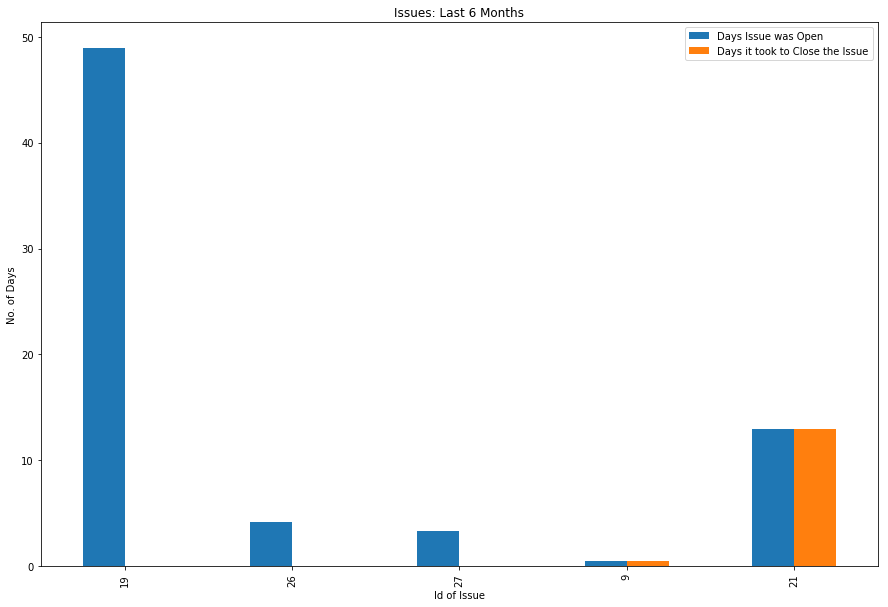

In [7]:
plot = results.plot(x=['id_in_repo'], kind='bar', title='Issues: Last 6 Months', figsize=(15,10))
plot.set_xlabel('Id of Issue')
plot.set_ylabel('No. of Days')
legend = plot.legend()
legend.get_texts()[0].set_text('Days Issue was Open')
legend.get_texts()[1].set_text('Days it took to Close the Issue')